# Build a pairs trading strategy with Python

* Pairs trading (sometimes called statistical arbitrage) is a way of trading an economic relationship between two stocks. For example, two companies that manufacture a similar product with the same supply chain will be impacted by the same economic forces. Pairs trading tries to model that relationship and make money when the relationship temporarily breaks down.

* Pairs trading relies on cointegration. Cointegration is a statistical method to test the stationarity between two-time series. Stationarity describes a time series that has no trend, a constant variance through time, and no seasonality. The “pair” is a linear combination of both stocks: one you buy and one you sell.

### Pairs trading exploits periodic breakdowns in economic relationships.

* An ideal pairs trading scenario is when two stocks are cointegrated. In other words, there is a stable linear combination between them. The strategy will enter trades if that relationship breaks down.

* The secret to pairs trading is picking the right pairs to trade. To do this, traders start with buckets of stocks that are related economically. Then they use big data sets to crunch through millions of pairs to find anomalies to exploit.

# Step 1: Get the data
Start by importing the libraries. statsmodels is a package used to build statistical models like linear regression and tests for cointegration. seaborn is a plotting library. 

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf
import seaborn
import matplotlib.pyplot as plt

Next, get the data. Picking the pairs to test is the secret behind a good pairs trading strategy. For this example, I just use the FAANG stocks.

In [2]:
symbol_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
data = yf.download(
    symbol_list, 
    start='2014-01-01', 
    end='2015-01-01'
)['Adj Close']

[*********************100%%**********************]  5 of 5 completed


# Step 2: Find co-integrated pairs
The next step is to loop through the different combinations of pairs to test if they’re co-integrated (see Warning below).

In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

This function loops through a list of securities and tests for cointegration between all pairs. It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than 0.05.

Next, run the function on our stock data.

In [4]:
scores, pvalues, pairs = find_cointegrated_pairs(data)

And plot the results on a heat map.


<Axes: >

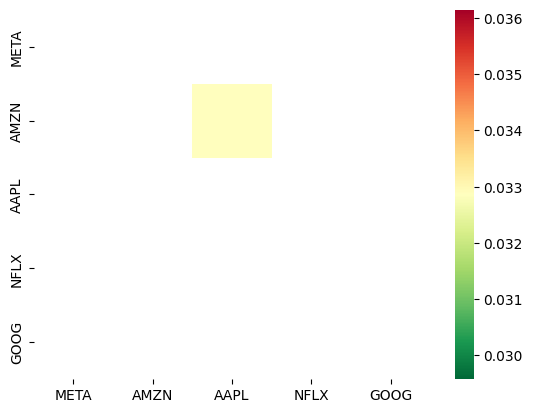

In [5]:
seaborn.heatmap(
    pvalues, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= 0.05)
)

It looks like AMZN and AAPL are co-integrated!

Step 3: Model the spread
Now that you found a pair, run a linear regression using statsmodels and model the spread as a linear combination of AAPL and AMZN. b is the beta coefficient from the linear regression, otherwise known as the “hedge ratio.”

In [7]:
S1 = data.AMZN
S2 = data.AAPL

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1.AMZN
b = results.params['AMZN']
spread = S2 - b * S1

Now plot it.

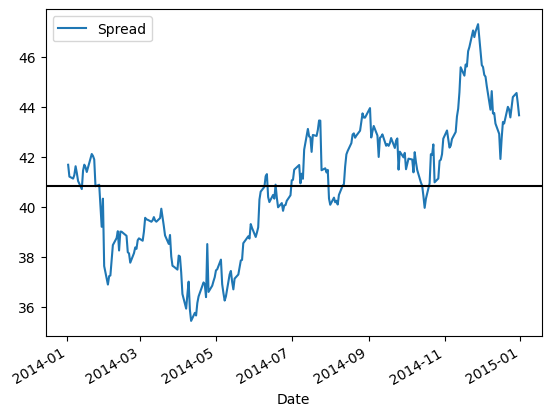

In [8]:
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

# Step 4: Build a simple trading strategy
You buy the spread when it gets “too low” and sell the spread when it gets “too high.” But what is too low and too high? Use the z-score to normalize the spread and use it as the trade signal. If you buy the pair, you buy AAPL and sell b shares of AMZN. If you sell the pair, you sell AAPL and buy b shares of AMZN.

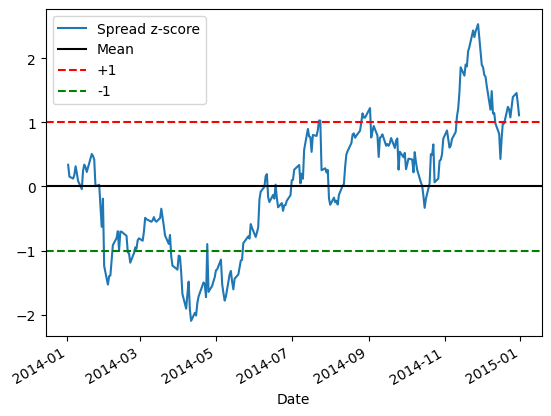

In [9]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

First, build a function that plots the z-score.

Next, estimate the equity curve of buying and selling the pair.

In [10]:
# Create a DataFrmae with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

First, create a DataFrame with the signal and the position in the pair. Then add a column to the DataFrame and populate it with a 1 when the signal is less than or equal to -1 and -1 when the signal is greater than or equal to 1.

Finally, plot the equity curve.

<Axes: xlabel='Date'>

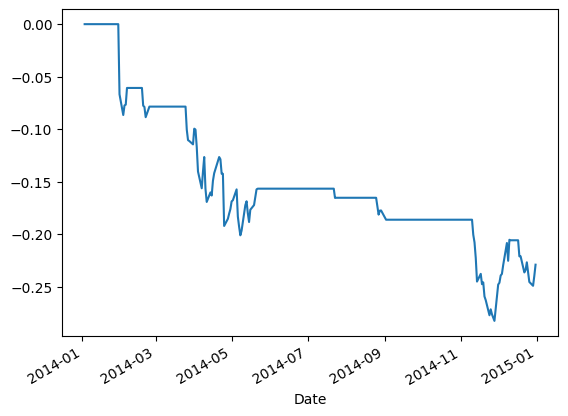

In [11]:
returns = trades.position.pct_change() * trades.side
returns.cumsum().plot()

# Warning:
This is a toy example and there are some important caveats to note:

Pairs trading assumes stock prices are cointegrated. Technically, that means that a linear combination of prices varies around a stable mean on the same distribution. In practice, traders use Augmented Dickey-Fuller tests, Hurst exponents, and Kalman filters to test for cointegration.
Looping through pairs to find p-values increases the likelihood of incorrectly finding a significant p-value when many tests are run (a false positive). Start with the economic rationale of why two stocks should be cointegrated. In practice, traders pick a handful of stocks with economic links and test those.
​

Well, that's it for today. I hope you enjoyed it.